In [1]:
import ujson
import numpy 
import datetime
from collections import Counter, defaultdict

import sys, os
sys.path.append(os.getcwd())

from filter_data import user_project_filter, print_datastats

## 1. Load Data

In [2]:
# loads pre-computed counts of each active block type per project for every user 
blockcounts = ujson.load(open('user_project_allblockcounts.json'))
# loads other stats 
othercounts = ujson.load(open('user_project_othercounts.json'))
print_datastats(blockcounts)

46320 users and 1546033 projects


In [3]:
for user in blockcounts:
    projects = blockcounts[user].keys()
    for project in projects:
        if sum(blockcounts[user][project].values())==0:
            blockcounts[user].pop(project)
            othercounts[user].pop(project)
print_datastats(blockcounts)

46320 users and 1385816 projects


## 2. Get Language Labels

The languages labels are inferred from the `namestrings_to_langs.py` script using `langid`.

In [4]:
isocodes = ujson.load(open('isocodes.json'))  # mapping from  iso code to language name
user_langs = ujson.load(open('user_inferredlangs.json'))  # mapping from userid to inferred language
# remove uncommon languages
lang_counts = Counter()
for user in user_langs:
    lang = user_langs[user]
    lang_counts[lang] += 1
    
user_langs = {user: lang for user, lang in user_langs.items() if lang_counts[lang]>=250 and user in blockcounts}
langset = set(user_langs.values())
print 'lang data created with', len(user_langs), 'users and', len(langset), 'languages', langset

# filter these users from code summaries
blockcounts = {user: blockcounts[user] for user in user_langs}
othercounts = {user: othercounts[user] for user in user_langs}
print_datastats(blockcounts)

lang data created with 43160 users and 11 languages set([u'el', u'fr', u'en', u'zh', u'pt', u'ca', u'de', u'ko', u'it', u'th', u'es'])
43160 users and 1300201 projects


Create a map from each language to the set of users assigned to that language.

In [5]:
lang_users = defaultdict(set)  
for user in user_langs:
    lang = user_langs[user]
    lang_users[lang].add(user)
print sorted([(len(lang_users[lang]), lang) for lang in lang_users])

[(257, u'th'), (291, u'el'), (322, u'fr'), (451, u'de'), (470, u'ca'), (838, u'pt'), (862, u'it'), (3605, u'ko'), (4926, u'es'), (9950, u'zh'), (21188, u'en')]


[291, 322, 21188, 9950, 838, 470, 451, 3605, 862, 257, 4926]
[u'el', u'fr', u'en', u'zh', u'pt', u'ca', u'de', u'ko', u'it', u'th', u'es']


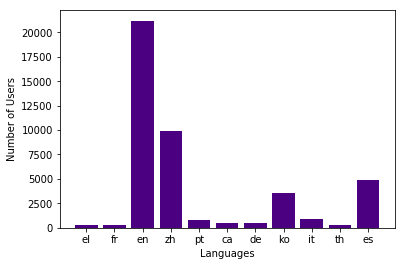

In [7]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_langs(lang_users, filename=None):
    y_pos = np.arange(len(lang_users))
    numusers = [len(lang_users[lang]) for lang in lang_users]
    plt.bar(y_pos, numusers, color = 'indigo', align='center')
    print numusers
    print lang_users.keys()
    plt.xticks(y_pos, lang_users.keys())
    plt.ylabel('Number of Users')
    plt.xlabel('Languages')
    #plt.title('User Language Distribution')
    if filename:
        plt.savefig(filename)
    plt.show()
    
plot_langs(lang_users)

## 2. Filter Unoriginal Projects

Run the cells below only if we want to filter.

Filter projects that are identical to several projects from many users (results of `identify_similar.py` and `process_graph.py`).

In [6]:
hypnontutorials = ujson.load(open('user_hypnontutorial_projects.json'))
blockcounts = user_project_filter(blockcounts, hypnontutorials)
othercounts = user_project_filter(othercounts, hypnontutorials)
print_datastats(blockcounts)

39456 users and 316955 projects


Finally, discard any users with too few projects after the above filtering steps.

23447 users and 277308 projects
[216, 293, 12214, 3432, 657, 346, 368, 1907, 735, 171, 3108]
[u'el', u'fr', u'en', u'zh', u'pt', u'ca', u'de', u'ko', u'it', u'th', u'es']


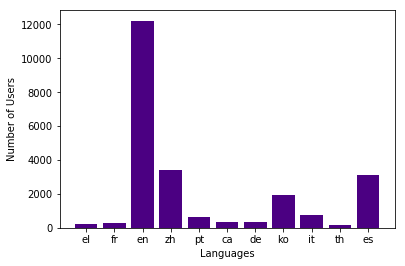

In [8]:
blockcounts_final = {user: blockcounts[user] for user in blockcounts if len(blockcounts[user])>=5}
othercounts_final = {user: othercounts[user] for user in othercounts if user in blockcounts_final}
print_datastats(blockcounts_final)

filtered_lang_users = {}
for lang in lang_users:
    filtered_lang_users[lang] = lang_users[lang].intersection(blockcounts_final)
plot_langs(filtered_lang_users, 'filtered_lang_dist.png')

Language groups.

[12214, 5510, 5723]
['english', 'asian', 'european']


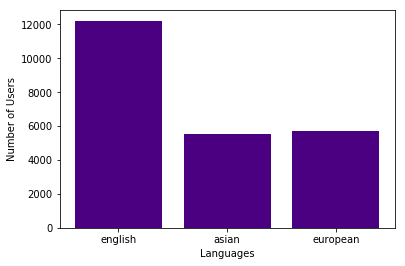

In [9]:
langgroups = {'es': 'european',
              'pt': 'european', 
              'it': 'european', 
              'de': 'european', 
              'fr': 'european', 
              'ca': 'european', 
              'el': 'european', 
              'nl': 'european', 
              'pl': 'european',
              'en': 'english',
              'ko': 'asian', 
              'zh': 'asian', 
              'th': 'asian'}
user_lang_groups = {user: langgroups[lang] for user, lang in user_langs.items() if lang in langgroups.keys()}
grouped_lang_users = defaultdict(set)
for lang in langgroups:
    if lang in filtered_lang_users:
        grouped_lang_users[langgroups[lang]].update(filtered_lang_users[lang])
plot_langs(grouped_lang_users, 'langgroup_dist.png')

Histogram of number of projects.

['5-10', '10-15', '15-20', '20-25', '25+'] 5
[12460, 5751, 2587, 1306, 1343] 5


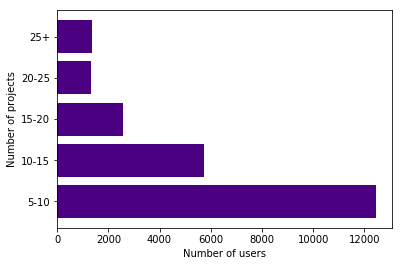

In [10]:
project_counts = [len(blockcounts_final[user]) for user in blockcounts_final]
hist, bins = np.histogram(project_counts, bins=range(5, 26, 5))
project_counts_over = len([p for p in project_counts if p>25])
bins = bins.astype(str)
bins = [bins[i]+'-'+bins[i+1] for i in range(len(bins)-1)]
hist = list(hist)
bins.append('25+')
hist.append(project_counts_over)
print bins, len(bins)
print hist, len(hist)
pos = np.arange(len(hist))
plt.figure(figsize=(6, 4))
plt.barh(pos, hist, color = 'indigo', align='center')
plt.yticks(pos, bins)
plt.xlabel('Number of users')
plt.ylabel('Number of projects')
#plt.title('User Project Counts')
plt.savefig('projectcounts.png')
plt.show()


## 2. Featurize (Code)

In [11]:
import code_features
reload(code_features)

def combine_featfuncs(funclist):
    def combined(user):
        basedict = funclist[0](user)
        for f in funclist[1:]:
            basedict.update(f(user))
        return basedict
    return combined

In [36]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder 

GROUPLANG = 'binarynoen'   # binaryen (combine european and english), no (no grouping)
labels = []
featurized = []
userlist = blockcounts_final.keys()
for user in userlist:
    if GROUPLANG.startswith('binary'):
        labels.append(user_lang_groups[user])
        featurized.append(code_features.get_all_blocks(blockcounts_final[user]))
    else:
        labels.append(user_langs[user])  # uncollapsed languages
        featurized.append(code_features.get_all_blocks(blockcounts_final[user]))
    
le = LabelEncoder()
if GROUPLANG.startswith('binary'):
    y = le.fit_transform([label if label!='english' else 'european' for label in labels])
else:
    y = le.fit_transform(labels)

codevec = DictVectorizer()
Xcode = codevec.fit_transform(featurized).todense()

from sklearn.preprocessing import scale
Xcode = scale(Xcode)

In [37]:
print Xcode.shape

(23447, 1450)


### Static Train-Test Split

In [38]:
from sklearn.model_selection import StratifiedKFold
trainidx, testidx = ujson.load(open('traintest.json'))
if GROUPLANG=='binarynoen':
    trainidx = [idx for idx in trainidx if labels[idx]!='english']
    testidx = [idx for idx in testidx if labels[idx]!='english']

In [39]:
le.classes_

array(['asian', 'european'], 
      dtype='|S8')

### Model Training and Testing

Building a feedfwd model with 1450 features
Chance is 0.50975177305
Accuracy: 0.789007092199


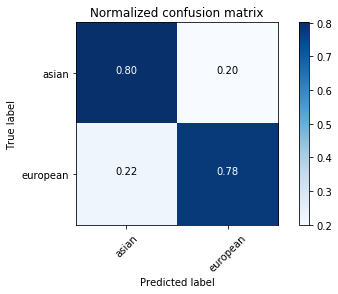

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import plotcnf
reload(plotcnf)
from sklearn.decomposition import PCA

classifiers = [
            #('logreg_l1', LogisticRegression(penalty = 'l1', class_weight='balanced')),
              #('logreg_l2', LogisticRegression(penalty = 'l2', class_weight='balanced')),
             # ('random_forest', RandomForestClassifier(criterion='entropy'), max_depth=2),
             # ('knn', KNeighborsClassifier(n_neighbors=10)),
            ('feedfwd', MLPClassifier(hidden_layer_sizes=(100,), solver='adam'))
            ]     

for modelname, model in classifiers:
    for featname, X in [('code', Xcode)]:

        print  'Building a', modelname, 'model with', X.shape[1], 'features'
        
        ytrain = y[trainidx]
        ytest = y[testidx]

        print 'Chance is', max(numpy.bincount(ytest))/float(len(ytest))

        Xtrain = X[trainidx, :]  
        Xtest = X[testidx, :]
            
        model.fit(Xtrain, ytrain)
        print 'Accuracy:', model.score(Xtest, ytest)             
        #coefs = coefs/len(foldindices)
        #if modelname == 'logreg_l1':
        #    importances = sorted(filter(lambda x:x[0]!=0, zip(coefs, codevec.feature_names_)), reverse=True)
        #    print importances
        if modelname=='random_forest':
            importances = sorted(zip(model.feature_importances_, codevec.feature_names_), reverse=True)
            print importances[:10]
        #analyze last fold only
        predictions = model.predict(Xtest)
        cnf_matrix = confusion_matrix(ytest, predictions)  
        plotcnf.plot_confusion_matrix(cnf_matrix, le.classes_, normed=True)
        plt.show()
        

In [ ]:
for i in range(model.coefs_[0].shape[1]):
    feats = np.argsort(model.coefs_[0][:, i])[-5:]
    print i
    for feat in feats:
        print codevec.feature_names_[feat], model.coefs_[0][feat, i]